#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
path = '/content/drive/MyDrive/project5/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
is_final = True

In [5]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [7]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [8]:
def replace_under_iqr(total, cols):
    df = total.copy()
    for c in cols:
        tmp = df[c]

        Q3, Q1 = tmp.quantile(0.75), tmp.quantile(0.25)
        IQR = Q3 - Q1

        idx = np.argwhere((tmp < (Q1 - 1.5 * IQR))).reshape(-1, )
        tmp.loc[idx] = np.NaN

        df[c] = tmp

    return df

def make_datetime(data):
    data['weekday'] = data['Date'].dt.weekday
    data['month'] = data['Date'].dt.month
    data['week'] = data['Date'].dt.isocalendar().week

    return data

def decomp(df, period):
    decomp = sm.tsa.seasonal_decompose(df['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'trend':decomp.trend, 'seasonal':decomp.seasonal})
    return result

def merge_dataset(sales, products, stores, orders, oil_price, store_id, product_id):

    stores['State'] = stores['State'].str.replace('\t', '')

    new_oil_price = (oil_price.set_index('Date').asfreq('1D')
                    .interpolate(method='linear')
                    .bfill())

    sales_loc = sales.loc[(sales['Store_ID'] == store_id) & (sales['Product_ID'] == product_id)]
    products_loc = products.loc[products['Product_ID'] == product_id]
    stores_loc = stores.loc[stores['Store_ID'] == store_id]
    orders_loc = orders.loc[orders['Store_ID'] == store_id]

    total = pd.merge(sales_loc, products_loc,
                    how='left',
                    on=['Product_ID'])

    total = pd.merge(total, orders_loc,
                    how='left',
                    on=['Date', 'Store_ID'])

    total = pd.merge(total, stores_loc,
                    how='left',
                    on=['Store_ID'])

    total = pd.merge(new_oil_price, total,
                     how='left',
                     on=['Date'])

    df = total[['Date', 'WTI_Price', 'Qty', 'CustomerCount']]

    replaced_df = replace_under_iqr(df, ['WTI_Price', 'Qty', 'CustomerCount'])

    final_df = replaced_df.interpolate(method='linear').bfill()

    final_df = make_datetime(final_df)

    final_df = pd.get_dummies(final_df, columns=['weekday'],
                              drop_first=True,
                              dtype=int)

    final_df['Qty_5d'] = final_df['Qty'].shift(5)
    final_df['Qty_12d'] = final_df['Qty'].shift(12)

    final_df['Qty_7ma'] = final_df['Qty'].rolling(7).mean()
    final_df['Qty_28ma'] = final_df['Qty'].rolling(28).mean()

    final_df['WTI_Price_7ma'] = final_df['WTI_Price'].rolling(7).mean()
    final_df['WTI_Price_28ma'] = final_df['WTI_Price'].rolling(28).mean()

    final_df['CustomerCount_7ma'] = final_df['CustomerCount'].rolling(7).mean()
    final_df['CustomerCount_28ma'] = final_df['CustomerCount'].rolling(28).mean()

    final_df['Qty_ma_diff'] = final_df['Qty_7ma'] - final_df['Qty_28ma']
    final_df['WTI_Price_ma_diff'] = final_df['WTI_Price_7ma'] - final_df['WTI_Price_28ma']
    final_df['CustomerCount_ma_diff'] = final_df['CustomerCount_7ma'] - final_df['CustomerCount_28ma']

    decomp_qty = decomp(final_df, 7) # period 7
    real_final_df = pd.concat([final_df,decomp_qty], axis=1)

    real_final_df.drop(['Date'], axis=1, inplace=True)
    real_final_df.dropna(axis=0, inplace=True)

    real_final_df.reset_index(drop=True, inplace=True)

    return real_final_df

In [9]:
beverage = merge_dataset(sales, products, stores, orders, oil_price, 44, 3)
milk = merge_dataset(sales, products, stores, orders, oil_price, 44, 12)
agriculture = merge_dataset(sales, products, stores, orders, oil_price, 44, 42)

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [10]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def print_metrics(y_true, y_pred):
    print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
    print(f"MAE: {mean_absolute_error(y_val, pred)}")
    print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
    print(f"R2 Score: {r2_score(y_val, pred)}")

## **(1) LSTM 모델링**

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.saving import load_model

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [12]:
df = beverage

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 10000

scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 7)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

(1057, 7, 24) (1057,)


* **모델링**

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
RMSE: 0.11941007089937482
MAE: 0.08645166351477306
MAPE: 0.07705613220248396
R2 Score: 0.8981763299711858


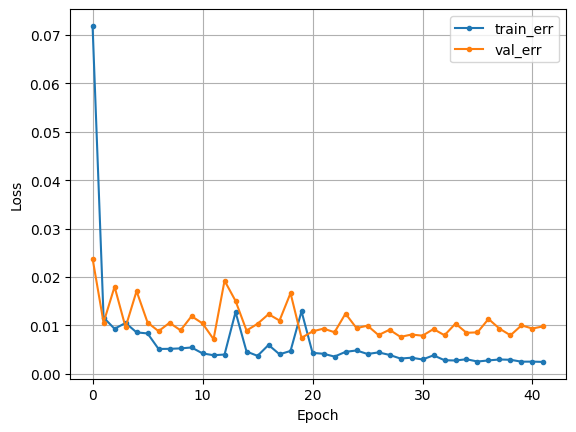

In [13]:
if is_final:
    beverage_model = load_model(path + 'outputs/beverage_gru_best_model.keras')
    history = pd.read_pickle(path + 'outputs/beverage_gru_history.pkl')

    # 모델 평가
    pred = beverage_model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    dl_history_plot(history)

else:
    # 딥러닝 베이스라인 모델 생성
    input_shape = x_train.shape[1:]

    fit_params = {
        'epochs': 150,
        'batch_size': 32
    }

    lr = 0.003

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(128, activation='tanh', return_sequences=True)) # 추가된 GRU 레이어
    model.add(GRU(128, activation='tanh', return_sequences=False)) # 추가된 GRU 레이어
    model.add(Dense(1))
    model.compile(loss='huber', optimizer=Adam(0.003))

    # callbacks
    es = EarlyStopping(patience=30, restore_best_weights=True)

    # 모델 학습
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        callbacks=[es],
                        **fit_params)

    # 모델 평가
    pred = model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    plot_model_result(y_train, y_val, pred)
    dl_history_plot(history.history)

### **2) 상품 : 12 - Milk**

### 남다윤

In [14]:
df = milk

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 100

scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 3)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

(1061, 3, 24) (1061,)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
RMSE: 8.798731852431935
MAE: 6.244448491414389
MAPE: 0.05355017732680326
R2 Score: 0.9259562119720991


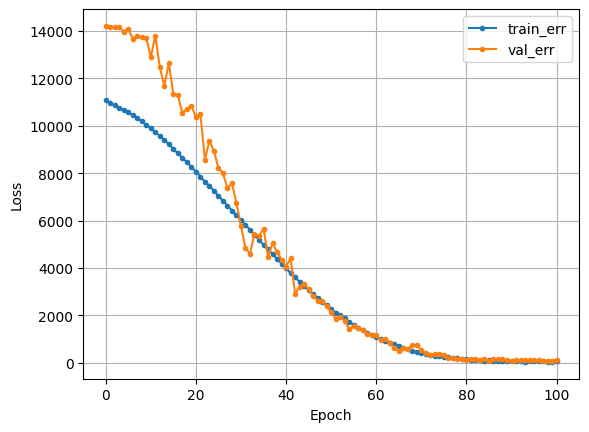

In [15]:
if is_final:
    milk_model = load_model(path + 'outputs/best_model_milk_925.keras')
    history = pd.read_pickle(path + 'outputs/history_milk_925.pkl')

    # 모델 평가
    pred = milk_model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    dl_history_plot(history)

else:
    # 딥러닝 베이스라인 모델 생성
    input_shape = x_train.shape[1:]

    fit_params = {
        'epochs': 500,
        'batch_size': 32
    }

    lr = 0.001

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=False))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(30,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1)) # input_shape는 feature의 개수
    model.compile(loss='mse', optimizer=Adam(lr))

    # callbacks
    es = EarlyStopping(monitor='val_loss',
                       verbose=1,
                       patience=10,
                       restore_best_weights=True,
                       min_delta=0)

    # 모델 학습
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        callbacks=[es],
                        **fit_params)

    # 모델 평가
    pred = model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    plot_model_result(y_train, y_val, pred)
    dl_history_plot(history.history)

### **3) 상품 : 42 - Agricultural products**

### 이예림

In [16]:
df = milk

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 1000

scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 7)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

(1057, 7, 24) (1057,)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
RMSE: 1.1238515574051544
MAE: 0.863225283432007
MAPE: 0.07361088620199237
R2 Score: 0.879200157677593


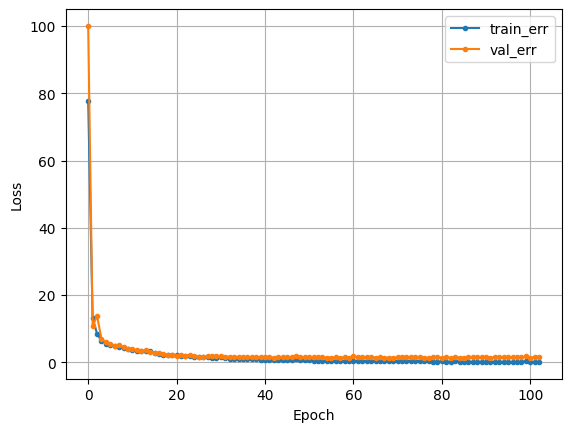

In [17]:
if is_final:
    milk_model = load_model(path + 'outputs/milk_best_model.keras')
    history = pd.read_pickle(path + 'outputs/milk_history.pkl')

    # 모델 평가
    pred = milk_model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    dl_history_plot(history)

else:
    # 딥러닝 베이스라인 모델 생성
    input_shape = x_train.shape[1:]

    fit_params = {
        'epochs': 200,
        'batch_size': 32
    }

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(SimpleRNN(64, activation='tanh', return_sequences=True))  # 첫 번째 RNN 레이어
    model.add(SimpleRNN(64, activation='tanh', return_sequences=False))  # 두 번째 RNN 레이어
    model.add(Dense(1))  # 출력 레이어
    model.compile(loss='mse', optimizer=Adam())

    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # 모델 학습
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        callbacks=[es],
                        **fit_params)

    # 모델 평가
    pred = model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    plot_model_result(y_train, y_val, pred)
    dl_history_plot(history.history)

### 안다희

In [18]:
df = agriculture

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 100

scaler = MinMaxScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 3)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

(1061, 3, 24) (1061,)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step
RMSE: 0.033112582948488206
MAE: 0.027456089138984677
MAPE: 0.03257625053990122
R2 Score: 0.9505428448137857


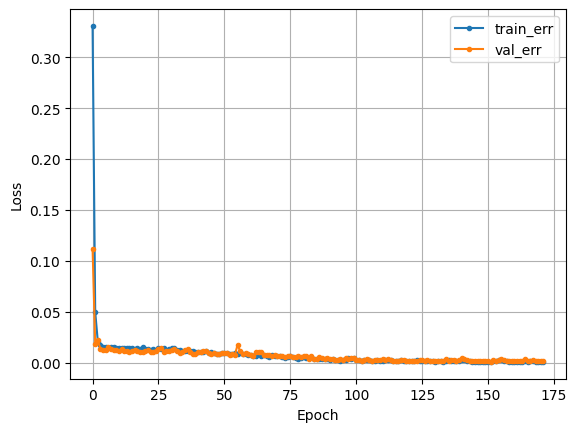

In [19]:
if is_final:
    agriculture_model = load_model(path + 'outputs/agriculture_best_model.keras')
    history = pd.read_pickle(path + 'outputs/agriculture_history.pkl')

    # 모델 평가
    pred = agriculture_model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    dl_history_plot(history)

else:
    # 딥러닝 베이스라인 모델 생성
    input_shape = x_train.shape[1:]

    fit_params = {
        'epochs': 200,
        'batch_size': 32
    }

    lr = 0.01

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(LSTM(64, activation='tanh', return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(lr))

    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=20,
                                   restore_best_weights=True)

    # 모델 학습
    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                        callbacks=[es],
                        **fit_params)

    # 모델 평가
    pred = model.predict(x_val)
    print_metrics(y_val, pred)

    # 결과 시각화
    plot_model_result(y_train, y_val, pred)
    dl_history_plot(history.history)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [37]:
from keras.models import load_model

beverage_model = load_model(path + 'outputs/beverage_gru_best_model.keras')
milk_model = load_model(path + 'outputs/best_model_milk_925.keras')
agriculture_model = load_model(path + 'outputs/agriculture_best_model.keras')

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [38]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [54]:
sales_tmp = pd.concat([sales, sales_test], axis=0)
orders_tmp = pd.concat([orders, orders_test], axis=0)
oil_price_tmp = pd.concat([oil_price, oil_price_test], axis=0)

In [131]:
beverage_test = merge_dataset(sales_tmp, products, stores, orders_tmp, oil_price_tmp, 44, 3)
milk_test = merge_dataset(sales_tmp, products, stores, orders_tmp, oil_price_tmp, 44, 12)
agriculture_test = merge_dataset(sales_tmp, products, stores, orders_tmp, oil_price_tmp, 44, 42)

In [132]:
train = [beverage, milk, agriculture]
test = [beverage_test, milk_test, agriculture_test]
scaled = []
idx = 0

for df_train, df_test in zip(train, test):
    df_train['target'] = df_train['Qty'].shift(-2)
    dataset = df.dropna(axis=0)

    x_ = dataset.drop(['target'], axis=1)

    if idx == 2:
        scaler = MinMaxScaler()

    else:
        scaler = StandardScaler()

    _ = scaler.fit_transform(x_)
    df_test = scaler.transform(df_test)

    scaled.append(df_test)
    idx += 1

test_config  =  {
    'beverage': {'dataset': scaled[0],
                 'model': beverage_model,
                 'scale': 10000,
                 'timestamp': 7,
                 'preds': []},

    'milk': {'dataset': scaled[1],
             'model': milk_model,
                 'scale': 100,
                 'timestamp': 3,
                 'preds': []},

    'agriculture': {'dataset': scaled[2],
                 'model': agriculture_model,
                 'scale': 100,
                 'timestamp': 3,
                 'preds': []}
}

* 예측해보기

In [133]:
train = [beverage, milk, agriculture]

for data in test_config.keys():
    x_test, _ = temporalize(pd.DataFrame(test_config[data]['dataset']),
                            pd.DataFrame(test_config[data]['dataset']),
                            test_config[data]['timestamp'])

    x_test = x_test.astype(np.float32)

    tmp_pred = test_config[data]['model'].predict(x_test)
    final_preds = tmp_pred * test_config[data]['scale']

    test_config[data]['preds'] = final_preds

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [105]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [168]:
y_b = (sales_test[(sales_test['Store_ID'] == 44) & (sales_test['Product_ID'] == 3)]['Qty']
     .shift(-2).
     dropna(axis=0)[:-1])
y_m = (sales_test[(sales_test['Store_ID'] == 44) & (sales_test['Product_ID'] == 12)]['Qty']
     .shift(-2).
     dropna(axis=0)[:-1])
y_a = (sales_test[(sales_test['Store_ID'] == 44) & (sales_test['Product_ID'] == 42)]['Qty']
     .shift(-2).
     dropna(axis=0)[:-1])

In [212]:
# beverage
beverage_inv = inv_simulator(np.array(y_b), np.array(test_config['beverage']['preds'][-28:]), 8800, 8)

일평균 재고량     : 21686.038
일평균 재고 금액  : 173488.304
일평균 재고회전율 : 0.701
기회손실 수량     : 0.0


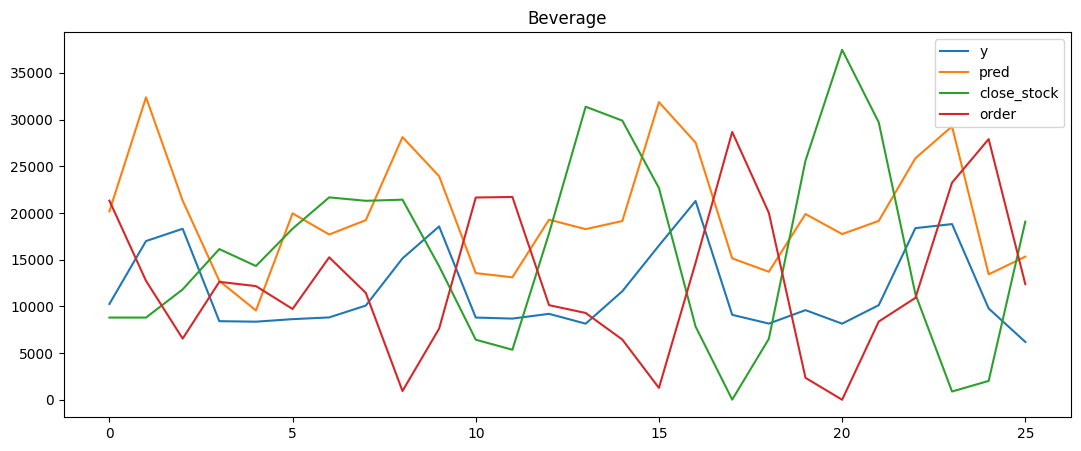

In [213]:
plt.figure(figsize=(13, 5))

plt.title('Beverage')

plt.plot(beverage_inv['y'], label='y')
plt.plot(beverage_inv['pred'], label='pred')
plt.plot(beverage_inv['close_stock'], label='close_stock')
plt.plot(beverage_inv['order'], label='order')

plt.legend()
plt.savefig('./beverage.png', bbox_inches='tight', dpi=300)

In [208]:
# milk
milk_inv = inv_simulator(np.array(y_m), np.array(test_config['milk']['preds'][-28:]), 7500, 6)

일평균 재고량     : 17534.288
일평균 재고 금액  : 105205.728
일평균 재고회전율 : 0.798
기회손실 수량     : 0.0


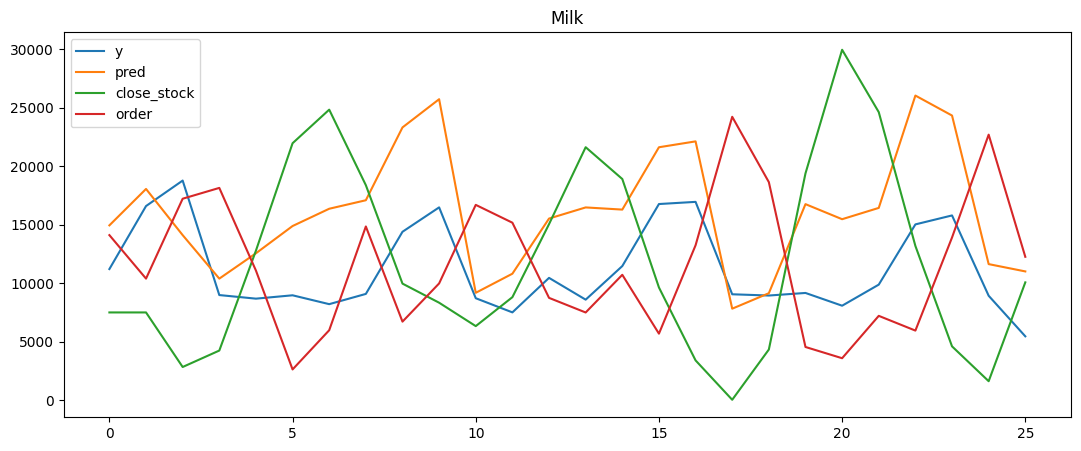

<Figure size 640x480 with 0 Axes>

In [209]:
plt.figure(figsize=(13, 5))

plt.title('Milk')

plt.plot(milk_inv['y'], label='y')
plt.plot(milk_inv['pred'], label='pred')
plt.plot(milk_inv['close_stock'], label='close_stock')
plt.plot(milk_inv['order'], label='order')

plt.legend()
plt.show()

plt.savefig('./milk.png', bbox_inches='tight', dpi=300)

In [210]:
# agricultual
agri_inv = inv_simulator(np.array(y_a), np.array(test_config['agriculture']['preds'][-28:]), 15, 5)

일평균 재고량     : 71.135
일평균 재고 금액  : 355.675
일평균 재고회전율 : 1.611
기회손실 수량     : 0.0


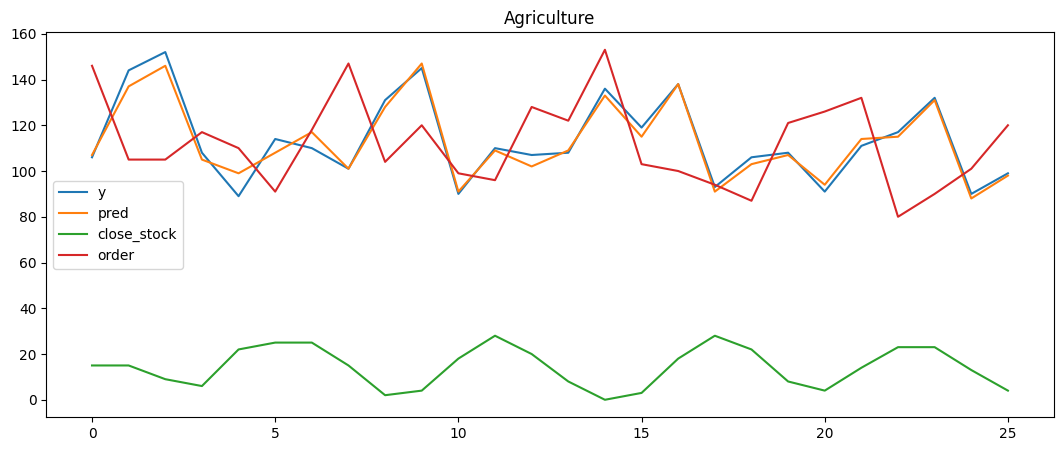

<Figure size 640x480 with 0 Axes>

In [211]:
plt.figure(figsize=(13, 5))

plt.title('Agriculture')

plt.plot(agri_inv['y'], label='y')
plt.plot(agri_inv['pred'], label='pred')
plt.plot(agri_inv['close_stock'], label='close_stock')
plt.plot(agri_inv['order'], label='order')

plt.legend()
plt.show()

plt.savefig('./agri.png', bbox_inches='tight', dpi=300)